In [1]:
import glob
import os
import time

# from tqdm import tnrange, tqdm_notebook
from tqdm import tqdm

# from skimage.transform import resize
# from skimage import data, color

import tensorflow.keras.backend as K
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout,BatchNormalization,Activation,PReLU,LeakyReLU, Add, Lambda
from tensorflow.keras.layers import UpSampling2D, Conv2D, MaxPooling2D, Conv2DTranspose, GlobalAveragePooling2D, ZeroPadding2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

# from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras import initializers
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam,RMSprop

from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.utils import HDF5Matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.utils import shuffle

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

2621


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  after removing the cwd from sys.path.


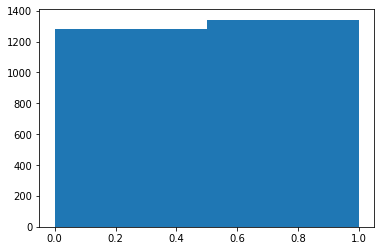

In [2]:
x_train = (h5py.File('camelyonpatch_level_2_split_train_x.h5', 'r')['x'][:, 16:80,16:80]) #- 127.5) / 127.5
y_train = h5py.File('camelyonpatch_level_2_split_train_y.h5', 'r')['y'].value.reshape(-1,1)
x_valid = (h5py.File('camelyonpatch_level_2_split_valid_x.h5', 'r')['x'][:, 16:80,16:80]) #- 127.5) / 127.5
y_valid = h5py.File('camelyonpatch_level_2_split_valid_y.h5', 'r')['y'].value.reshape(-1,1)

percent_10 = int(x_train.shape[0]*.01)
np.random.seed(17)
idx10 = np.random.choice(range(x_train.shape[0]), percent_10, replace=False)

x_train_10 = x_train[idx10]
y_train_10 = y_train[idx10]
plt.hist(y_train_10, bins=2)
print(percent_10)

In [11]:
from sklearn.cluster import KMeans
import scipy
from scipy.cluster.vq import kmeans, whiten, vq
from mpl_toolkits.mplot3d import Axes3D
a = x_train_10
b = a.reshape(-1, 64*64, 3)
# w = whiten(b)

# stds = np.std(b, axis=1)

m = b.mean(axis=1)
print(m.shape)
b.shape

(2621, 3)


(2621, 4096, 3)

In [12]:
def get_dominant_color(img_vector, k_means=3):
    cluster_centers, distortion = kmeans(img_vector.astype(np.float32),k_means)
    vecs, dist = vq(img_vector, cluster_centers)         # assign codes
    counts, bins = scipy.histogram(vecs, len(cluster_centers))
    return cluster_centers[scipy.argmax(counts)]

In [13]:
dominants = np.array([get_dominant_color(img) for img in b])
dominants.shape

(2621, 3)

<BarContainer object of 4 artists>

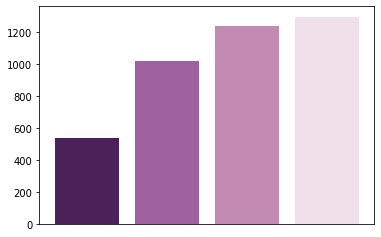

In [34]:
cluster_centers, _ = kmeans(dominants.astype(np.float32), 4)

vecs, dist = scipy.cluster.vq.vq(b[i], cluster_centers)         # assign codes
counts, bins = scipy.histogram(vecs, len(cluster_centers))    # count occurrences

# plt.figure(figsize=(5,2))
# plt.axis('off')
# plt.imshow((cluster_centers[scipy.argsort(counts)]/255.0).reshape(1,-1,3))

plt.figure()
plt.xticks([])
plt.bar(range(4),counts[scipy.argsort(counts)], color=(cluster_centers[scipy.argsort(counts)]/255.0))


In [ ]:
i = np.random.randint(a.shape[0]-1)

cluster_centers, distortion = kmeans(b[i].astype(np.float32), 3)

# plt.imshow((cluster_centers*stds[i]/255).reshape(1,-1,3))
plt.figure(figsize=(5,2))
plt.imshow((cluster_centers[cluster_centers.mean(axis=1).argsort()]/255.0).reshape(1,-1,3))

# plt.figure(figsize=(2,2))
# plt.imshow(m[i].reshape(1,-1,3)/255)

vecs, dist = scipy.cluster.vq.vq(b[i], cluster_centers)         # assign codes
counts, bins = scipy.histogram(vecs, len(cluster_centers))    # count occurrences

plt.figure(figsize=(2,2))
plt.imshow((cluster_centers[scipy.argmax(counts)]/255.0).reshape(1,-1,3))

plt.figure(figsize=(5,2))
plt.imshow((get_dominant_color(b[i], 3)/255.0).reshape(1,-1,3))


plt.figure(figsize=(5,5))
plt.imshow(a[i].reshape(64,64,3))
# 72, 19, 20, 99, 61, 37

i

1359

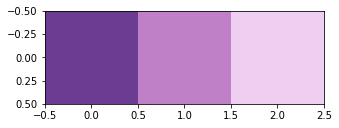

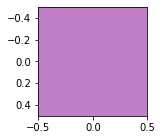

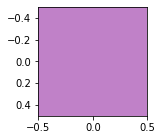

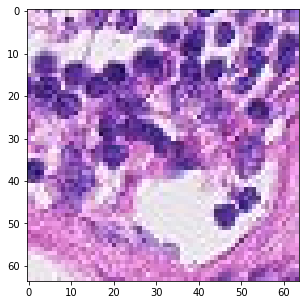

In [17]:
i = np.random.randint(a.shape[0]-1)

cluster_centers, distortion = kmeans(b[i].astype(np.float32), 3)

# plt.imshow((cluster_centers*stds[i]/255).reshape(1,-1,3))
plt.figure(figsize=(5,2))
plt.imshow((cluster_centers[cluster_centers.mean(axis=1).argsort()]/255.0).reshape(1,-1,3))

# plt.figure(figsize=(2,2))
# plt.imshow(m[i].reshape(1,-1,3)/255)

vecs, dist = scipy.cluster.vq.vq(b[i], cluster_centers)         # assign codes
counts, bins = scipy.histogram(vecs, len(cluster_centers))    # count occurrences

plt.figure(figsize=(2,2))
plt.imshow((cluster_centers[scipy.argmax(counts)]/255.0).reshape(1,-1,3))

plt.figure(figsize=(5,2))
plt.imshow((get_dominant_color(b[i], 3)/255.0).reshape(1,-1,3))


plt.figure(figsize=(5,5))
plt.imshow(a[i].reshape(64,64,3))
# 72, 19, 20, 99, 61, 37

i

In [536]:
import scipy
import binascii
vecs, dist = scipy.cluster.vq.vq(b[i], cluster_centers)         # assign codes
counts, bins = scipy.histogram(vecs, len(cluster_centers))    # count occurrences

index_max = scipy.argmax(counts)                    # find most frequent
peak = cluster_centers[index_max]
colour = binascii.hexlify(bytearray(int(c) for c in peak)).decode('ascii')
print('most frequent is %s (#%s)' % (peak, colour))

most frequent is [250.17801 249.81873 249.54567] (#faf9f9)


In [537]:
counts

array([2529,  168, 1399])

[2 1 2 1 0 0 0 2 2 0 0 0 0 0 0 0 2 0 0 2 2 0 2 0 0 0 2 0 0 0 1 0 2 0 0 0 2
 0 2 2 0 0 2 0 0 0 0 0 0 0 0 0 1 2 2 0 2 0 2 0 2 2 2 0 0 1 0 1 1 0 0 0 0 0
 0 2 1 0 1 1 2 1 1 2 1 1 2 2 0 0 0 0 2 2 2 1 2 0 2 1]


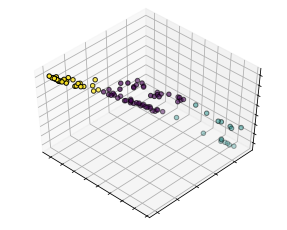

In [631]:
est = KMeans(n_clusters=3, random_state=0).fit(dominants)
fig = plt.figure(figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
labels = est.labels_

ax.scatter(dominants[:, 0], dominants[:,1], dominants[:, 2], c=labels.astype(np.float), edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
# ax.set_xlabel('Petal width')
# ax.set_ylabel('Sepal length')
# ax.set_zlabel('Petal length')
print(labels)

In [ ]:
idx = np.where(labels==0)[0]
for i in idx:
    plt.figure(figsize=(2,2))
    plt.imshow(a[i])
#     plt.
# labels[i]

In [482]:
np.where(labels==0)[0][0]

7

(array([67., 57., 54., 60., 65., 57., 55., 57., 68., 60.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

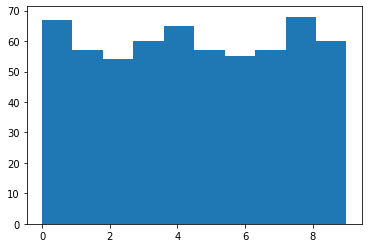

In [2]:
# import cv2

(x_train, y_train), (x_valid, y_valid) = mnist.load_data()
x_train = (x_train.astype(np.float32)[:,:,:, np.newaxis] - 127.5) / 127.5
x_valid = (x_valid.astype(np.float32)[:,:,:, np.newaxis] - 127.5) / 127.5

percent_10 = int(x_train.shape[0]*.01)
np.random.seed(17)
idx10 = np.random.choice(range(x_train.shape[0]), percent_10, replace=False)

x_train_10 = x_train[idx10]
y_train_10 = y_train[idx10]
plt.hist(y_train_10, bins=10)

In [4]:
def create_critic_final(width, height, channels, kernel_size=3):
    """ Declare discriminator """

    model = Sequential()

    model.add(Conv2D(32, kernel_initializer=initializers.RandomNormal(mean=0,stddev=0.2), 
                     kernel_size=kernel_size, strides=2, 
                     input_shape=(width, height, channels), padding="same"))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.15))

    model.add(Conv2D(64, kernel_size=kernel_size, strides=2, padding="same",
             kernel_initializer=initializers.RandomNormal(mean=0,stddev=0.2)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.15))

    model.add(Conv2D(128, kernel_size=kernel_size, strides=2, padding="same",
             kernel_initializer=initializers.RandomNormal(mean=0,stddev=0.2)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.15))

    model.add(Flatten())
    model.add(Dense(256,
             kernel_initializer=initializers.RandomNormal(mean=0,stddev=0.2)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.15))

    model.add(Dense(1,
             kernel_initializer=initializers.RandomNormal(mean=0,stddev=0.2)))

    return model

def create_actor_final(width, height, channels, latent_dim=100):
    
    model = Sequential()

    model.add(Dense(32*int(width/4)*int(height/4), input_dim=latent_dim,
                    kernel_initializer=initializers.RandomNormal(mean=0,stddev=0.2)))
#     model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
    model.add(Activation('relu'))
    model.add(Reshape((int(width/4),int(height/4), 32)))

    model.add(UpSampling2D(interpolation='nearest'))
    model.add(Conv2D(64, kernel_size=3, strides=1, padding="same"))
#     model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
    model.add(Activation('relu'))

    model.add(UpSampling2D(interpolation='nearest'))
    model.add(Conv2D(48, kernel_size=4, strides=2, padding="same"))
#     model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
    model.add(Activation('relu'))
    
    model.add(UpSampling2D(interpolation='nearest'))
    model.add(Conv2D(32, kernel_size=3, strides=1, padding="same"))
#     model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
    model.add(Activation('relu'))

    model.add(UpSampling2D(interpolation='nearest'))
    model.add(Conv2D(16, kernel_size=4, strides=2, padding="same"))
#     model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
    model.add(Activation('relu'))
 
    model.add(Conv2D(8, kernel_size=3, strides=1, padding="same"))
#     model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
    model.add(Activation('relu'))

    model.add(UpSampling2D(interpolation='nearest'))
    model.add(Conv2D(16, kernel_size=4, strides=2, padding="same"))
#     model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
    model.add(Activation('relu'))
    
    model.add(Conv2D(channels, kernel_size=3, strides=1, padding="same"))
    model.add(Activation("tanh"))
    
    return model

In [5]:
def wasserstein_loss(y_true,y_pred):
    return K.mean(y_true*y_pred)

In [4]:
def build_conv(width, height, channels, num_labels):
#     model = Sequential(name='conv')
#     model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(width, height, channels), padding="same"))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(BatchNormalization(momentum=0.8))
    
#     model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
# #     model.add(ZeroPadding2D(padding=((0,1),(0,1))))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(BatchNormalization(momentum=0.8))

#     model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(BatchNormalization(momentum=0.8))

#     model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(BatchNormalization(momentum=0.8))
    
#     model.add(Flatten())
#     model.add(Dense(256))
#     model.add(LeakyReLU(alpha=0.1))
#     model.add(BatchNormalization(momentum=0.8))

#     model.add(Dropout(0.25))

#     model.add(Dense(num_labels))
    
#     return model

    conv = Sequential(name='conv')
    conv.add(Conv2D(128, kernel_size=3, strides=2, input_shape=(width, height, channels), padding="same"))
    conv.add(LeakyReLU(alpha=0.2))
#     conv.add(BatchNormalization())
    
    conv.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    conv.add(LeakyReLU(alpha=0.2))
#     conv.add(BatchNormalization())

    conv.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    conv.add(LeakyReLU(alpha=0.2))
#     conv.add(BatchNormalization())
    
    conv.add(Flatten())
#     conv.add(Dense(256))
#     conv.add(LeakyReLU(alpha=0.1))
#     conv.add(BatchNormalization(momentum=0.8))

    conv.add(Dropout(0.4))

    conv.add(Dense(num_labels))
    return conv


def build_classifier(conv):
    model = Sequential(name='classifier')
    model.add(conv)
    model.add(Activation('softmax'))
    return model

def build_discriminator(conv):
    model = Sequential(name='discriminator')
    model.add(conv)
    
    def predict1(output):
        logexpsum = K.sum(K.exp(output), axis=-1, keepdims=True)
        result = logexpsum / (logexpsum + 1.0)
        return result
    
    def predict(y):
        p = 1.0 - (1.0 / (K.sum(K.exp(y), axis=-1, keepdims=True) + 1.0))
        return p

    model.add(Lambda(predict))
#     model.add(Activation('sigmoid'))
    
    return model


def build_gen(width, height, channels, latent_dim):
#     model = Sequential(name='gen')
#     model.add(Dense(32*int(width/4)*int(height/4), input_dim=latent_dim))
#     model.add(Activation('relu'))
#     model.add(Reshape((int(width/4),int(height/4), 32)))
#     model.add(BatchNormalization(momentum=0.8))

# #     model.add(UpSampling2D())
#     model.add(UpSampling2D(interpolation='nearest'))
#     model.add(Conv2D(32, kernel_size=3, strides=1, padding="same"))
#     model.add(Activation('relu'))
#     model.add(BatchNormalization(momentum=0.8))

# #     model.add(UpSampling2D())
#     model.add(UpSampling2D(interpolation='nearest'))
#     model.add(Conv2D(32, kernel_size=4, strides=2, padding="same"))
#     model.add(Activation('relu'))
#     model.add(BatchNormalization(momentum=0.8))
    
# #     model.add(UpSampling2D())
#     model.add(UpSampling2D(interpolation='nearest'))
#     model.add(Conv2D(16, kernel_size=3, strides=1, padding="same"))
#     model.add(Activation('relu'))
#     model.add(BatchNormalization(momentum=0.8))

# #     model.add(UpSampling2D())
# #     model.add(UpSampling2D(interpolation='nearest'))
# #     model.add(Conv2D(16, kernel_size=4, strides=2, padding="same"))
# #     model.add(Activation('relu'))
#     model.add(BatchNormalization(momentum=0.8))
 
#     model.add(Conv2D(8, kernel_size=3, strides=1, padding="same"))
#     model.add(Activation('relu'))
# #     model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))

# #     model.add(UpSampling2D())
# #     model.add(UpSampling2D(interpolation='nearest'))
# #     model.add(Conv2D(16, kernel_size=4, strides=2, padding="same"))
# #     model.add(Activation('relu'))
#     model.add(BatchNormalization(momentum=0.8))
    
#     model.add(Conv2D(channels, kernel_size=3, strides=1, padding="same"))
#     model.add(Activation("tanh"))

    model = Sequential(name='generator')
    
    model.add(Dense(128*int(width/4)*int(height/4), input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((int(width/4),int(height/4), 128)))
#     model.add(BatchNormalization(momentum=0.8))

    model.add(UpSampling2D(interpolation='nearest'))
    model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
#     model.add(BatchNormalization(momentum=0.8))

    model.add(UpSampling2D(interpolation='nearest'))
    model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
#     model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(channels, kernel_size=3, strides=1, padding="same"))
    model.add(Activation("tanh"))
    
    return model


def build_gan(gen, dis):
    model = Sequential(name='gan')
    model.add(gen)
    model.add(dis)
    return model


def build(width, height, channels, latent_dim, num_labels):

    conv = build_conv(width, height, channels, num_labels)
    clf = build_classifier(conv)
    dis = build_discriminator(conv)
    gen = build_gen(width, height, channels, latent_dim)

#     opt = Adam(clipvalue=1.0, lr=0.0002, beta_1=0.5)
#     opt_weak = Adam(clipvalue=0.1, lr=0.0001)
    
    opt = Adam(lr=0.0002, beta_1=0.5)
    opt_weak = Adam(lr=0.0002, beta_1=0.5)

    clf_loss = 'sparse_categorical_crossentropy'
    clf.compile(loss=clf_loss, metrics=['accuracy'], optimizer=opt_weak)

    dis_loss = 'binary_crossentropy'
    dis.compile(loss=dis_loss, optimizer=opt)

    dis.trainable = False
    gan = build_gan(gen, dis)
    gan_loss = 'binary_crossentropy'
    gan.compile(loss=gan_loss, optimizer=opt)

    return clf, dis, gen, gan

def simple_clf(width, height, channels, num_labels):
    conv = build_conv(width, height, channels, num_labels)
    clf = build_classifier(conv)

    clf_loss = 'sparse_categorical_crossentropy'
    clf.compile(loss=clf_loss, metrics=['accuracy'], optimizer=Adam(lr=0.0002, beta_1=0.5))  
    return clf

epoch 1:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.5959608629345894 0.6843872


epoch 2:   0%|          | 0/64 [00:00<?, ?it/s]

0.5100085373851471 0.7451782


epoch 3:   2%|▏         | 1/64 [00:00<00:12,  4.93it/s]

0.5208127003279515 0.74920654


epoch 4:   0%|          | 0/64 [00:00<?, ?it/s]

0.5101893459795974 0.7475281


epoch 5:   0%|          | 0/64 [00:00<?, ?it/s]

0.5144527858356014 0.74783325


epoch 6:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.5200694894301705 0.741333


epoch 7:   2%|▏         | 1/64 [00:00<00:12,  5.05it/s]

0.5221345705795102 0.7481079


epoch 8:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.49813196127070114 0.76049805


epoch 9:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.4995384491048753 0.77124023


epoch 10:   0%|          | 0/64 [00:00<?, ?it/s]

0.46347122197039425 0.7739258


epoch 11:   2%|▏         | 1/64 [00:00<00:12,  4.94it/s]

0.48031208268366754 0.76651


epoch 12:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.4925860314979218 0.7715454


epoch 13:   2%|▏         | 1/64 [00:00<00:12,  5.05it/s]

0.5241155758849345 0.7395935


epoch 14:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.4973547620465979 0.77459717


epoch 15:   0%|          | 0/64 [00:00<?, ?it/s]

0.4716097061173059 0.7735901


epoch 16:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.5690519640047569 0.71707153


epoch 17:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.5657395859016106 0.7234802


epoch 18:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.48914757958846167 0.7706604


epoch 19:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.4754154428374022 0.7785034


epoch 20:   0%|          | 0/64 [00:00<?, ?it/s]

0.5113006572355516 0.763031


epoch 21:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.4826132709858939 0.7652283


epoch 22:   0%|          | 0/64 [00:00<?, ?it/s]

0.47557486494770274 0.77664185


epoch 23:   2%|▏         | 1/64 [00:00<00:12,  5.03it/s]

0.49080286821117625 0.76742554


epoch 24:   2%|▏         | 1/64 [00:00<00:12,  5.05it/s]

0.4884278965764679 0.7685852


epoch 25:   0%|          | 0/64 [00:00<?, ?it/s]

0.48387179896235466 0.7687988


epoch 26:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.4834480685531162 0.77368164


epoch 27:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.502000188396778 0.761261


epoch 28:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.4985993747250177 0.7791748


epoch 29:   2%|▏         | 1/64 [00:00<00:12,  4.94it/s]

0.4652313224505633 0.7798157


epoch 30:   0%|          | 0/64 [00:00<?, ?it/s]

0.46891532716108486 0.7725525


epoch 31:   2%|▏         | 1/64 [00:00<00:12,  4.94it/s]

0.4750260215369053 0.7788391


epoch 32:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.47995453915791586 0.77282715


epoch 33:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.5015573943965137 0.75909424


epoch 34:   2%|▏         | 1/64 [00:00<00:12,  4.94it/s]

0.4664576613577083 0.77593994


epoch 35:   0%|          | 0/64 [00:00<?, ?it/s]

0.48545849905349314 0.7708435


epoch 36:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.48560571775306016 0.77059937


epoch 37:   2%|▏         | 1/64 [00:00<00:12,  5.05it/s]

0.5041163801797666 0.7668762


epoch 38:   2%|▏         | 1/64 [00:00<00:12,  5.05it/s]

0.5042031743214466 0.75912476


epoch 39:   2%|▏         | 1/64 [00:00<00:12,  4.94it/s]

0.49418339680414647 0.7673645


epoch 40:   0%|          | 0/64 [00:00<?, ?it/s]

0.5036122023011558 0.76297


epoch 41:   0%|          | 0/64 [00:00<?, ?it/s]

0.49959088809555396 0.7661438


epoch 42:   0%|          | 0/64 [00:00<?, ?it/s]

0.492907764215488 0.7628479


epoch 43:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.48836775950621814 0.77059937


epoch 44:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.5176639270212036 0.7336426


epoch 45:   0%|          | 0/64 [00:00<?, ?it/s]

0.49171336757717654 0.76651


epoch 46:   0%|          | 0/64 [00:00<?, ?it/s]

0.4885483444086276 0.76190186


epoch 47:   2%|▏         | 1/64 [00:00<00:12,  4.94it/s]

0.5199565286166035 0.7498779


epoch 48:   0%|          | 0/64 [00:00<?, ?it/s]

0.516898704925552 0.757782


epoch 49:   0%|          | 0/64 [00:00<?, ?it/s]

0.48832344892434776 0.76538086


epoch 50:   0%|          | 0/64 [00:00<?, ?it/s]

0.5407391067710705 0.74450684


epoch 51:   2%|▏         | 1/64 [00:00<00:12,  4.93it/s]

0.5151730313664302 0.75894165


epoch 52:   2%|▏         | 1/64 [00:00<00:12,  4.95it/s]

0.5017244825139642 0.7611084


epoch 53:   2%|▏         | 1/64 [00:00<00:12,  4.94it/s]

0.5079851760528982 0.76071167


epoch 54:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.5401172272395343 0.7302551


epoch 55:   0%|          | 0/64 [00:00<?, ?it/s]

0.5308103471179493 0.74282837


epoch 56:   2%|▏         | 1/64 [00:00<00:12,  4.94it/s]

0.5062511537107639 0.75860596


epoch 57:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.4973760399152525 0.7561035


epoch 58:   2%|▏         | 1/64 [00:00<00:12,  4.94it/s]

0.5003580111078918 0.7704773


epoch 59:   0%|          | 0/64 [00:00<?, ?it/s]

0.5316029358073138 0.7504883


epoch 60:   0%|          | 0/64 [00:00<?, ?it/s]

0.523180881747976 0.73703


epoch 61:   0%|          | 0/64 [00:00<?, ?it/s]

0.5143721559434198 0.7547302


epoch 62:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.5200314023531973 0.75115967


epoch 63:   0%|          | 0/64 [00:00<?, ?it/s]

0.5160038400208578 0.7454834


epoch 64:   0%|          | 0/64 [00:00<?, ?it/s]

0.5031653179321438 0.76782227


epoch 65:   0%|          | 0/64 [00:00<?, ?it/s]

0.499750888615381 0.75897217


epoch 66:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.5100579177378677 0.7573242


epoch 67:   2%|▏         | 1/64 [00:00<00:12,  5.03it/s]

0.5260242942604236 0.7474365


epoch 68:   2%|▏         | 1/64 [00:00<00:12,  4.94it/s]

0.5425232661073096 0.7212219


epoch 69:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.5131075224489905 0.7449646


epoch 70:   0%|          | 0/64 [00:00<?, ?it/s]

0.5087348570814356 0.75561523


epoch 71:   2%|▏         | 1/64 [00:00<00:12,  4.94it/s]

0.5157463168725371 0.7404175


epoch 72:   2%|▏         | 1/64 [00:00<00:12,  5.05it/s]

0.5100475898361765 0.7464905


epoch 73:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.5119604973588139 0.741272


epoch 74:   2%|▏         | 1/64 [00:00<00:12,  5.05it/s]

0.5335459326161072 0.71932983


epoch 75:   0%|          | 0/64 [00:00<?, ?it/s]

0.544815061322879 0.7190552


epoch 76:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.5223680537601467 0.7346802


epoch 77:   2%|▏         | 1/64 [00:00<00:12,  4.95it/s]

0.49545834120362997 0.7712097


epoch 78:   2%|▏         | 1/64 [00:00<00:12,  5.14it/s]

0.48825941141694784 0.76651


epoch 79:   2%|▏         | 1/64 [00:00<00:12,  5.03it/s]

0.4833731987164356 0.7688904


epoch 80:   0%|          | 0/64 [00:00<?, ?it/s]

0.49743421078892425 0.7652893


epoch 81:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.4780318338307552 0.77230835


epoch 82:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.48538648238172755 0.7651367


epoch 83:   0%|          | 0/64 [00:00<?, ?it/s]

0.5078663974418305 0.7264404


epoch 84:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.5147266442654654 0.761322


epoch 85:   0%|          | 0/64 [00:00<?, ?it/s]

0.49523600371321663 0.7595215


epoch 86:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.5330259682668839 0.7302551


epoch 87:   0%|          | 0/64 [00:00<?, ?it/s]

0.5038497506757267 0.76168823


epoch 88:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.5306754478951916 0.71139526


epoch 89:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.48593940818682313 0.76919556


epoch 90:   0%|          | 0/64 [00:00<?, ?it/s]

0.5294156182790175 0.7220459


epoch 91:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.4978831045445986 0.7604065


epoch 92:   2%|▏         | 1/64 [00:00<00:12,  4.94it/s]

0.4992460537177976 0.7540283


epoch 93:   2%|▏         | 1/64 [00:00<00:12,  5.03it/s]

0.5549510317214299 0.71377563


epoch 94:   2%|▏         | 1/64 [00:00<00:12,  4.94it/s]

0.4944190349779092 0.7619934


epoch 95:   0%|          | 0/64 [00:00<?, ?it/s]

0.5002770274295472 0.76364136


epoch 96:   2%|▏         | 1/64 [00:00<00:12,  4.94it/s]

0.4678442480508238 0.7715759


epoch 97:   2%|▏         | 1/64 [00:00<00:12,  4.94it/s]

0.4766025249264203 0.76989746


epoch 98:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.5170653373934329 0.75006104


epoch 99:   2%|▏         | 1/64 [00:00<00:12,  5.04it/s]

0.4977438292116858 0.7608948


epoch 99: 100%|██████████| 64/64 [00:12<00:00,  5.04it/s]


0.5018889677012339 0.747345


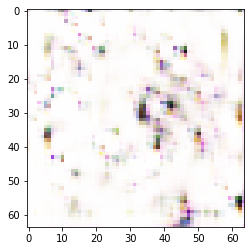

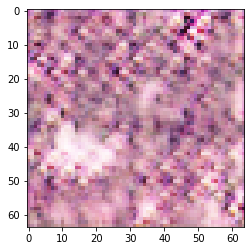

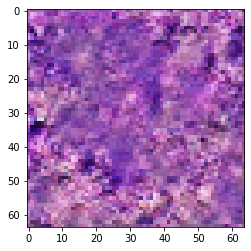

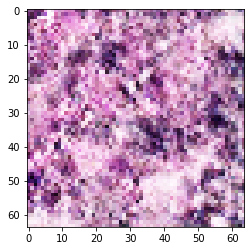

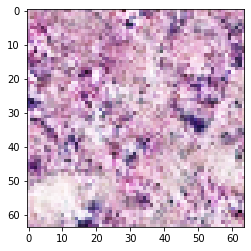

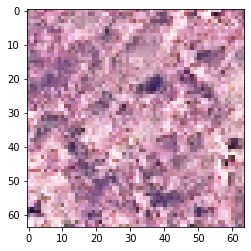

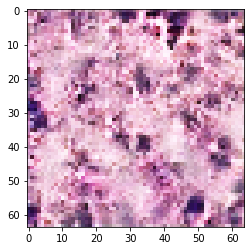

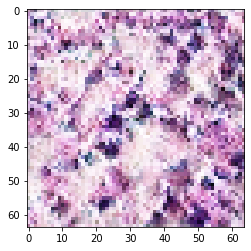

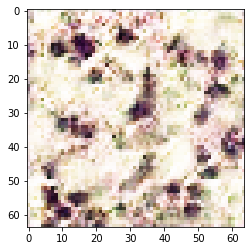

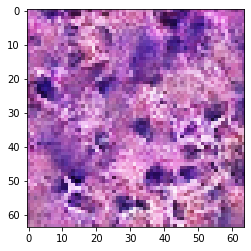

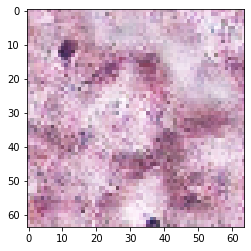

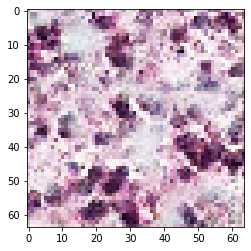

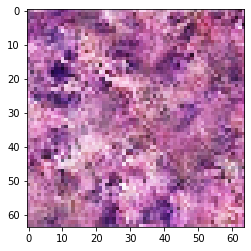

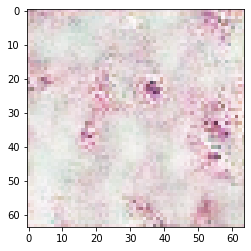

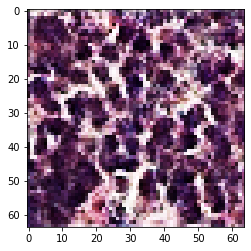

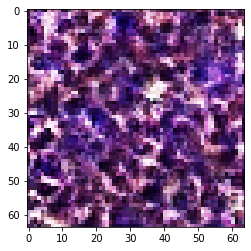

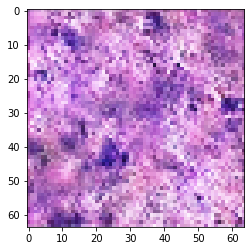

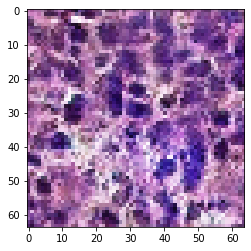

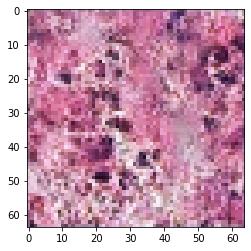

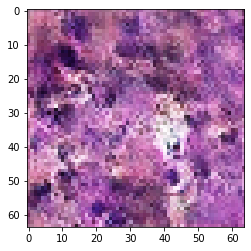

In [27]:
latent_dim = 100
num_labels=2

# d_real = np.ones((batch_size, 1))
# d_fake = np.zeros((batch_size, 1))

batch_size = 64
g_batch_size = int(batch_size*2)

Y = np.concatenate([np.ones((batch_size, 1))-.1, np.zeros((batch_size, 1))])

g_labels = np.ones((g_batch_size, 1))

classifier, discriminator, generator, gan = build(64, 64, 3, latent_dim, num_labels)

# discriminator.trainable = False
# gan_input = Input((latent_dim,))
# x = generator(gan_input)
# gan_output = discriminator(x)

# gan = Model(gan_input,gan_output)
# gan.compile(loss=wasserstein_loss,optimizer=RMSprop(lr=0.00005))


clf_loss_e = []
clf_acc_e = []

g_loss_e = []
d_loss_e=[]
d_acc_e=[]

idx_range = np.arange(x_train_10.shape[0])

for e in range(100):
    steps = 0
    g_loss = 0
    d_loss=0
    d_acc=0    
    for idx in tqdm(np.array_split(shuffle(idx_range), batch_size), desc="epoch "+str(e)):
        steps+=1
        imgs = x_train_10[idx]
        classifier.train_on_batch(imgs, y_train_10[idx])

        idx_u = np.random.choice(x_train.shape[0], batch_size, replace=False)
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        X = np.concatenate([x_train[idx_u],generator.predict(noise)])
        
        idx_d = shuffle(range(X.shape[0]))
        
        discriminator.trainable = True
#         weights = [np.clip(w, -0.01, 0.01) for w in discriminator.get_weights()]
#         discriminator.set_weights(weights)
        d_loss+= discriminator.train_on_batch(X[idx_d], Y[idx_d])
        discriminator.trainable = False

        noise = np.random.normal(0, 1, (g_batch_size, latent_dim))
        g_loss+=gan.train_on_batch(noise, g_labels)

    loss, acc = classifier.evaluate(x_valid, y_valid, batch_size=batch_size, verbose=0)
    print(loss, acc)
    clf_loss_e.append(loss)
    clf_acc_e.append(acc)
    g_loss_e.append(g_loss/steps)
    d_loss_e.append(d_loss/steps)
    
    if (e+1) % 5 == 0:
        noise = np.random.normal(0, 1, (1, latent_dim))
        gen_imgs = (generator.predict(noise)* 127.5 + 127.5).astype(np.int)
        plt.figure()
        plt.imshow(gen_imgs[0])
#     if np.isnan(loss):
#         break

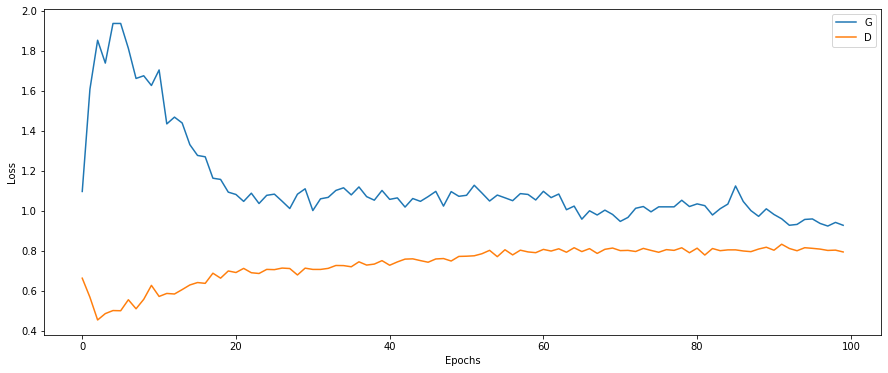

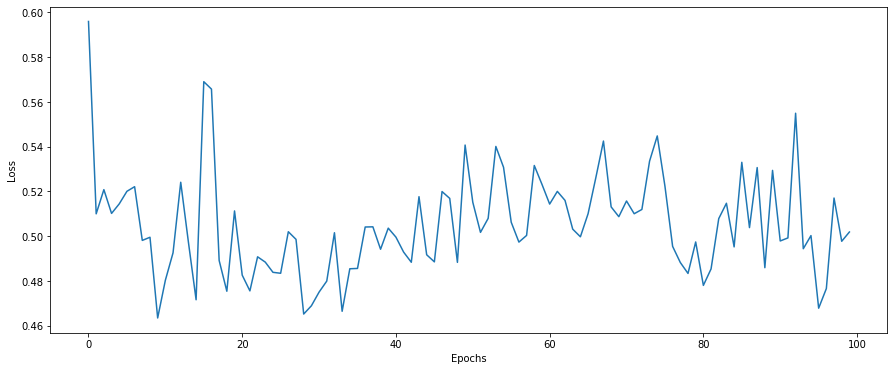

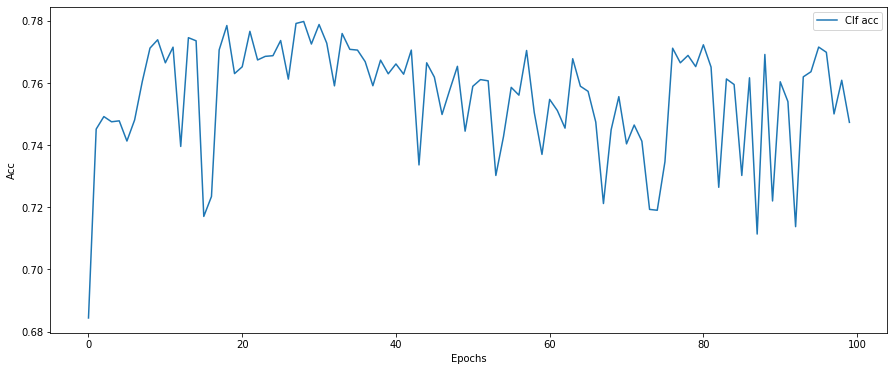

In [28]:
plt.figure(figsize=(15,6))
plt.plot(np.array(g_loss_e), label='G')
plt.plot(np.array(d_loss_e), label='D')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure(figsize=(15,6))
plt.plot(np.array(clf_loss_e), label='acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.legend()

plt.figure(figsize=(15,6))
plt.plot(np.array(clf_acc_e), label='Clf acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

In [10]:
# history = classifier.evaluate(x_valid, to_categorical(y_valid, num_classes=num_labels), batch_size=batch_size, verbose=0)
classifier.evaluate(x_valid, y_valid, batch_size=batch_size, verbose=0)

[0.5128703919472173, 0.7358093]

array([[8.1960046e-01, 1.8039960e-01, 7.5936868e-11, 4.3974879e-11,
        7.8478639e-12, 4.8730565e-11, 5.9233840e-11, 5.8512598e-11,
        9.8662870e-11, 1.0967822e-11]], dtype=float32)

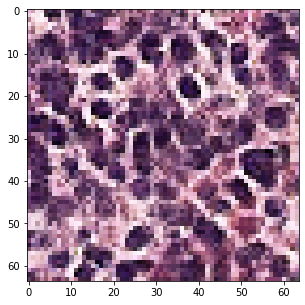

In [24]:
noise = np.random.normal(0, 1, (1, latent_dim))
gen_imgs = generator.predict(noise)
plt.figure(figsize=(5,5))
plt.imshow((gen_imgs[0]* 127.5 + 127.5).astype(np.int))
# plt.imshow(gen_imgs[0])
classifier.predict(gen_imgs)

In [3]:
def init_folders(name):
    if not os.path.exists('results'):
        os.mkdir('results')
    if not os.path.exists('results/'+name):
        os.mkdir('results/'+name)
        
def save_loss(name, epoch, Dloss, Gloss):
    path = 'results/'+name+'/loss'
    if not os.path.exists(path):
        os.mkdir(path)
    plt.figure(figsize=(10,8))
    plt.plot(Dloss,label='Dsicriminiative loss')
    plt.plot(Gloss,label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(path+'/loss_%d.png' % epoch)
    
def save_samples(folder, w, h, c, epoch, G,example=16, dim=(10,10),figsize=(10,10), randomDim=100):
    noise = np.random.normal(0,1,size=(example,randomDim))
    generatedImage = G.predict(noise)
    
    plt.figure(figsize=figsize)
    
    for i in range(example):
        plt.subplot(dim[0],dim[1],i+1)
        plt.imshow((generatedImage[i]* 127.5+127.5).astype(np.int32),interpolation='nearest',cmap='gray')
        '''drop the x and y axis'''
        plt.axis('off')
    plt.tight_layout()
    
    path = 'results/'+folder+'/samples'
    if not os.path.exists(path):
        os.mkdir(path)
    plt.savefig(path+'/epoch_%d.png' % epoch)
    
def save_models(name, epoch, d=None, g=None):
    path = 'results/'+name+'/models'
    if not os.path.exists(path):
        os.mkdir(path)
    g.save(path+'/G_%d.h5' % epoch)
    d.save(path+'/D_%d.h5' % epoch)
    
def get_model_memory_usage(batch_size, model):
    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    number_size = 4.0
    if K.floatx() == 'float16':
         number_size = 2.0
    if K.floatx() == 'float64':
         number_size = 8.0

    total_memory = number_size*(batch_size*shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes


# class CustomDataProvider:
#     def __init__(self, batch_size):
#         self.batch_size = batch_size
#         self.file = h5py.File('camelyonpatch_level_2_split_train_x.h5', 'r')
#         self.dataset = self.file['x']
#         self.input_shape = self.dataset[0].shape
#         self.image_number = self.dataset.shape[0]
        
#     def sample(self):
#         random_index = np.random.randint(0, self.image_number - self.batch_size)
#         return (self.dataset[random_index : random_index +  self.batch_size] - 127.5) / 127.5
        
#     def close(self):
#         if self.file:
#             self.file.close()
#         self.file = None
        
#     def __del__(self):
#         self.close()

class PcamDataProvider:
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self.file = h5py.File('camelyonpatch_level_2_split_train_x.h5', 'r')
        self.dataset = self.file['x']
        self.input_shape = self.dataset[0].shape
        self.image_number = self.dataset.shape[0]
        
    def sample(self):
        random_index = np.random.randint(0, self.image_number - self.batch_size)
        return (self.dataset[random_index : random_index +  self.batch_size] - 127.5) / 127.5
        
    def close(self):
        if self.file:
            self.file.close()
        self.file = None
        
    def __del__(self):
        self.close()
        
def crop_generator(batches):
    while True:
        batch_x, batch_y = next(batches)
        yield (batch_x[:, 16:80,16:80], batch_y)

In [4]:
def create_generic_CNN(width, height, channels):
    kernel_size=3
    model = Sequential()

    model.add(Conv2D(32, kernel_size=kernel_size, input_shape=(width, height, channels), padding="same", activation='elu'))
    model.add(MaxPooling2D(pool_size = 3))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))

    model.add(Conv2D(64, kernel_size=kernel_size, padding="same", activation='elu'))
    model.add(MaxPooling2D(pool_size = 3))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))

    model.add(Conv2D(128, kernel_size=kernel_size, padding="same", activation='elu'))
    model.add(MaxPooling2D(pool_size = 3))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    
    return model

def create_CNN(width, height, channels, n_classes=2, gpus=1):

    model = create_generic_CNN(width, height, channels)
    model.add(Flatten())
    model.add(Dense(128, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    
    loss='binary_crossentropy'
    if n_classes == 2:
        model.add(Dense(1, activation='sigmoid'))
    else:
        model.add(Dense(n_classes, activation='softmax'))
        loss = 'categorical_crossentropy'
        
    if gpus!=1:
        model = multi_gpu_model(model, gpus=gpus)
    
    model.compile(loss=loss,optimizer='adam', metrics=['accuracy'])


#     print('Critic')
    model.summary()

    return model

def create_GAP_CNN(width, height, channels, n_classes=2, gpus=8):
    model = create_generic_CNN(width, height, channels)
    
    model.add(GlobalAveragePooling2D())
    
    
    loss='binary_crossentropy'
    if n_classes == 2:
        model.add(Dense(1, activation='sigmoid'))
    else:
        model.add(Dense(n_classes, activation='softmax'))
        loss = 'categorical_crossentropy'
        
    if gpu!=1:
        model = multi_gpu_model(model, gpus=gpus)
    
    model.compile(loss=loss,optimizer='adam', metrics=['accuracy'])

#     print('Critic')
    model.summary()

    return model

def create_SG_G(width, height, channels, latent_dim):

    model = Sequential()
    
    model.add(Dense(32*int(width/4)*int(height/4), input_dim=latent_dim))
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
    model.add(Reshape((int(width/4),int(height/4), 32)))

    model.add(UpSampling2D())
#     model.add(UpSampling2D(interpolation='nearest'))
    model.add(Conv2D(64, kernel_size=3, strides=1, padding="same"))
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))

    model.add(UpSampling2D())
#     model.add(UpSampling2D(interpolation='nearest'))
    model.add(Conv2D(48, kernel_size=4, strides=2, padding="same"))
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
    
    model.add(UpSampling2D())
#     model.add(UpSampling2D(interpolation='nearest'))
    model.add(Conv2D(32, kernel_size=3, strides=1, padding="same"))
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))

    model.add(UpSampling2D())
#     model.add(UpSampling2D(interpolation='nearest'))
    model.add(Conv2D(16, kernel_size=4, strides=2, padding="same"))
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
 
    model.add(Conv2D(8, kernel_size=3, strides=1, padding="same"))
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))

    model.add(UpSampling2D())
#     model.add(UpSampling2D(interpolation='nearest'))
    model.add(Conv2D(16, kernel_size=4, strides=2, padding="same"))
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9, epsilon=0.00002))
    
    model.add(Conv2D(channels, kernel_size=3, strides=1, padding="same"))
    model.add(Activation("tanh"))

#     model.summary()

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

def create_SG_D(width, height, channels):

    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(width, height, channels), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())

#     model.summary()

    img = Input(shape=(width, height, channels))

    features = model(img)
#     valid = Dense(1, activation="sigmoid")(features)
#     label = Dense(3, activation="softmax")(features)
    valid = Dense(3, activation="softmax")(features)

#     return Model(img, [valid, label])
    return Model(img, valid)

def crate_SGGAN(width, height, channels, latent_dim=128, gpus=8):
        discriminator = create_SG_D(width, height, channels)
#         discriminator = multi_gpu_model(discriminator, gpus=gpus)
        
        optimizer='adam'

        discriminator.compile(
#             loss=['binary_crossentropy', 'categorical_crossentropy'],
#             loss_weights=[0.5, 0.5],
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

        # Build the generator
        generator = create_SG_G(width, height, channels, latent_dim)

        # The generator takes noise as input and generates imgs
        noise = Input(shape=(latent_dim,))
        img = generator(noise)

        # For the combined model we will only train the generator
        discriminator.trainable = False

        # The valid takes generated images as input and determines validity
#         valid, _ = discriminator(img)
        valid = discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        combined = Model(noise, valid)
#         combined = multi_gpu_model(combined, gpus=gpus)
#         combined.compile(loss=['binary_crossentropy'], optimizer=optimizer)
        combined.compile(loss='categorical_crossentropy',optimizer='adam')

        return discriminator, generator, combined


In [17]:
latent_dim = 128
discriminator, generator, combined = crate_SGGAN(*x_train_10.shape[1:], latent_dim)

In [7]:
batch_size = 64
half_batch = batch_size // 2
cw1 = {0: 1, 1: 1}
cw2 = {0: 2/half_batch, 1: 2/half_batch, 2: 1/half_batch}

valid = np.ones((batch_size))
fake = -np.ones((batch_size))

In [ ]:
d_loss = []
g_loss = []
for epoch in range(100000):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of images
        idx = np.random.randint(0, x_train_10.shape[0], batch_size)
        imgs = x_train_10[idx]

        # Sample noise and generate a batch of new images
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)

        # One-hot encoding of labels
        labels = to_categorical(y_train_10[idx], num_classes=3)
        fake_labels = to_categorical(np.full((batch_size, 1), 2), num_classes=3)
        
#         fake_labels = np.ones((batch_size, 3))
#         fake_labels[:,2] = -1

#         labels[labels==0] = -1
#         fake_labels[fake_labels==0] = -1
        X = np.concatenate([imgs,gen_imgs])
        Y = np.concatenate([labels,fake_labels])

        # Train the discriminator
        discriminator.trainable = True
        ### Clip weights ###
#         weights = [np.clip(w, -0.01, 0.01) for w in discriminator.get_weights()]
#         discriminator.set_weights(weights)
        
#         d_loss_real = discriminator.train_on_batch(imgs, [valid, labels], class_weight=[cw1, cw2])
#         d_loss_fake = discriminator.train_on_batch(gen_imgs, [fake, fake_labels], class_weight=[cw1, cw2])
#         d_loss.append(0.5 * np.add(d_loss_real, d_loss_fake))
        d_loss_real = discriminator.train_on_batch(X, Y)
        d_loss.append(d_loss_real)
        
        discriminator.trainable = False


        # ---------------------
        #  Train Generator
        # ---------------------

#         g_loss.append(combined.train_on_batch(noise, valid, class_weight=[cw1, cw2]))
        g_loss.append(combined.train_on_batch(noise, fake_labels))

#         print ("%d [D loss: %f, acc: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss))

#         if epoch % sample_interval == 0:
#             self.sample_images(epoch)

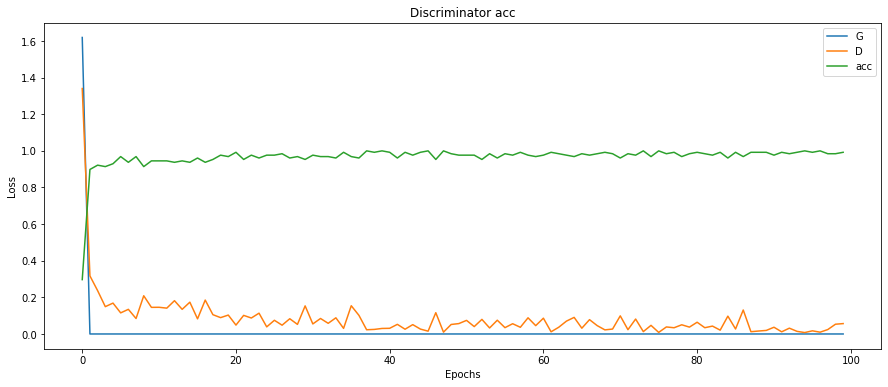

In [21]:
plt.figure(figsize=(15,6))
plt.plot(np.array(g_loss)[::1000], label='G')
plt.plot(np.array(d_loss)[::1000,0], label='D')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# plt.figure(figsize=(15,6))

# plt.plot(np.array(d_loss)[::100,0], label='acc')
plt.plot(np.array(d_loss)[::1000,1], label='acc')
plt.xlabel('Epochs')
plt.title('Discriminator acc')
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


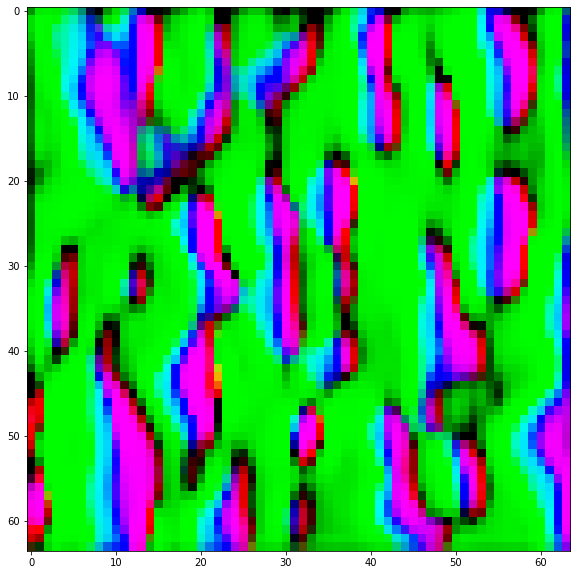

In [22]:
noise = np.random.normal(0, 1, (1, latent_dim))
gen_imgs = generator.predict(noise)
plt.figure(figsize=(10,10))
plt.imshow(gen_imgs[0])

In [ ]:
labels = to_categorical(y_valid, num_classes=3)
history = discriminator.evaluate(x_valid,labels, batch_size=64)

In [24]:
history

[1.1180260370019823, 0.7765198]

In [25]:
np.array(discriminator.predict(x_valid[:10])).argmax(axis=-1)

array([1, 0, 1, 1, 1, 1, 0, 1, 0, 1])

In [15]:
x_train[0,0,0]

array([0.38039216, 0.16078431, 0.4745098 ])

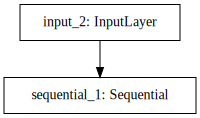

In [11]:
# SVG(model_to_dot(generator).create(prog='dot', format='svg'))

In [14]:
# x_train = h5py.File('camelyonpatch_level_2_split_train_x.h5', 'r')['x'][:, 16:80,16:80]/255.
# y_train = h5py.File('camelyonpatch_level_2_split_train_y.h5', 'r')['y'].value.reshape(-1,1)
# x_train = h5py.File('x_aug.h5', 'r')['x'].value
y_train = h5py.File('y_aug.h5', 'r')['y'].value
x_valid = h5py.File('camelyonpatch_level_2_split_valid_x.h5', 'r')['x'][:, 16:80,16:80]/255.
y_valid = h5py.File('camelyonpatch_level_2_split_valid_y.h5', 'r')['y'].value.reshape(-1,1)

# datagen = ImageDataGenerator(
# #     preprocessing_function=lambda x: x/255.,
#     rotation_range=180,
#     horizontal_flip=True,  # randomly flip images
#     vertical_flip=True)  # randomly flip images

# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():




In [32]:
x_train_10.shape

(2621, 64, 64, 3)

In [ ]:
# model = simple_clf(64,64,3, 2)
model, discriminator, generator, gan = build(64, 64, 3, 100, 2)


batch_size = 128
# training_gen = crop_generator(datagen.flow(x_train, y_train, batch_size=batch_size))
# valid_gen = crop_generator(datagen.flow(x_valid, y_valid, batch_size=batch_size))

checkpoint = ModelCheckpoint('weights.best.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
csv_logger = CSVLogger("model_history_log.csv", append=False)
early = EarlyStopping(monitor='val_loss', patience=16)

history = model.fit(x_train_10, y_train_10, batch_size=batch_size,
#                     steps_per_epoch=100, validation_steps = 100,
                    validation_data=(x_valid,y_valid),
                    epochs=1000, callbacks=[checkpoint, csv_logger, early],
                    workers = 6,use_multiprocessing=True
                   )



plt.plot(history.history['acc'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.figure()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

path = 'results/cnn_models'
if not os.path.exists(path):
    os.mkdir(path)
model.save(path+'/cnn_v1.h5')
model.save_weights(path+'/cnn_weights_v1.h5')

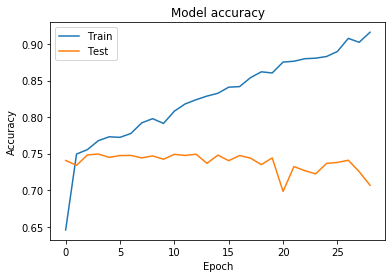

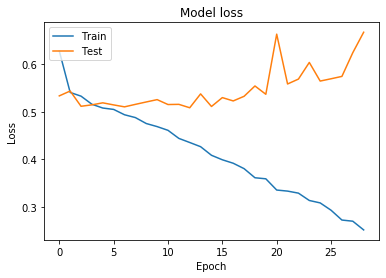

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.figure()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

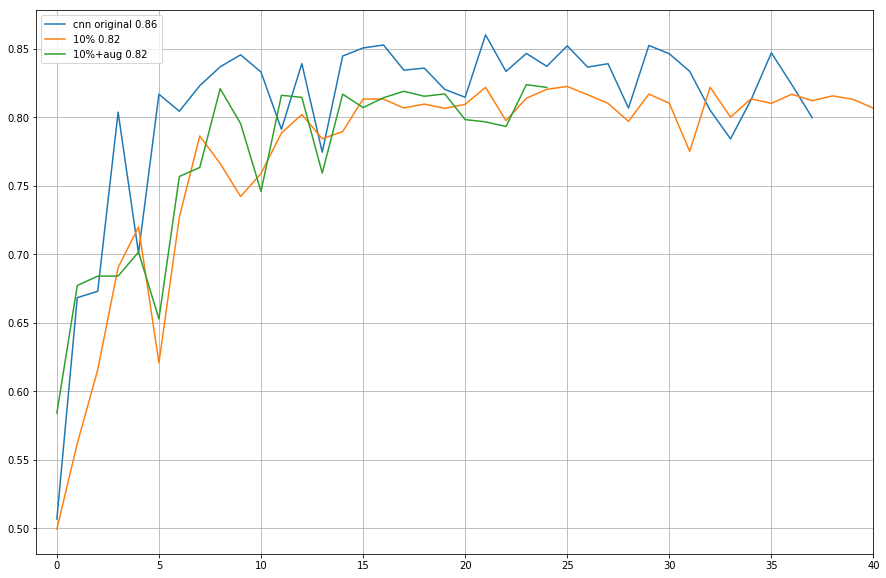

In [17]:
cnn = np.loadtxt('models/cnn_bn/cnn_bn_history.csv', delimiter=',', skiprows=1, usecols=3)
cnn10 = np.loadtxt('models/cnn_bn_10percent/cnn_bn_10percent_history.csv', delimiter=',', skiprows=1, usecols=3)[7::3]
cnn10_aug = np.loadtxt('models/cnn_bn_10percent_aug/cnn_bn_10percent_aug_history.csv', delimiter=',', skiprows=1, usecols=3)

plt.figure(figsize=(15,10))
plt.plot(cnn, label='cnn original {:0.2f}'.format(cnn.max()))
plt.plot(cnn10, label='10% {:0.2f}'.format(cnn10.max()))
plt.plot(cnn10_aug, label='10%+aug {:0.2f}'.format(cnn10_aug.max()))
plt.legend()
plt.xlim(-1,40)
plt.grid()

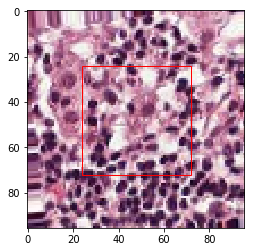

In [169]:
from matplotlib.patches import Rectangle

datagen = ImageDataGenerator(
              preprocessing_function=lambda x: x/255.,
    rotation_range=180,
#               horizontal_flip=True,  # randomly flip images
#               vertical_flip=True
)  # randomly flip images

img = datagen.flow(x_train[10:11])[0][0]
plt.imshow(img)
# Create a Rectangle patch
rect = Rectangle((24,24),48,48,linewidth=1,edgecolor='r',facecolor='none')
ax = plt.gca()
# Add the patch to the Axes
ax.add_patch(rect)

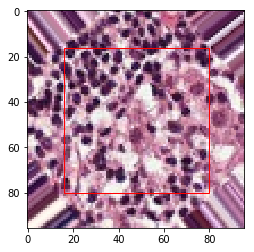

In [139]:
plt.imshow(img)
# Create a Rectangle patch
rect = Rectangle((16,16),64,64,linewidth=1,edgecolor='r',facecolor='none')
ax = plt.gca()
# Add the patch to the Axes
ax.add_patch(rect)

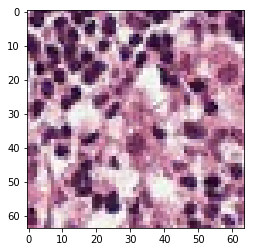

In [145]:
plt.imshow(img[16:16+64, 16:16+64])

16 80 16 80


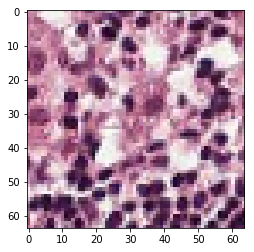

In [170]:
plt.imshow(center_crop(img, 64))

In [183]:
def center_crop(img, new_size):
    x,y,_ = img.shape
    x = x // 2
    y = y // 2
    size = new_size // 2
    return img[x-size:x+size, y-size:y+size]


def crop_generator(batches, new_size):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x = next(batches)
        print(batch_x.shape)
#         batch_crops = np.zeros((batch_x.shape[0], new_size, new_size, 3))
#         for i in range(batch_x.shape[0]):
#             batch_crops[i] = center_crop(batch_x[i], new_size)
        yield (batches[:, 16:80,16:80, :])

(1, 64, 64, 3)


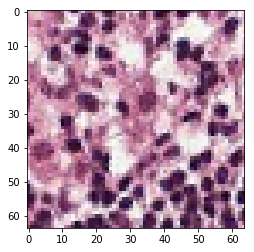

In [184]:
img = next(crop_generator(datagen.flow(x_train[10:11]), 64))[0]
plt.imshow(img)
